In [28]:
import pathlib
# Bikeshedding way to write to user directory
USER_DIR = str(pathlib.Path.home()) + '/'

In [29]:
#
# Load and parse data
#

import pandas as pd

bad_domains_path = '/data/all_types_domains_balanced_registered_domains_whois_parsed_correct_registrar_names_deduplicated_ids.json'
registar_domain_count_path = '/data/registrar_domain_count_flat_deduplicated.json'

bad_domains = pd.read_json(bad_domains_path, lines=True)
bad_domains = bad_domains.dropna(subset=['domain', 'created', 'registrar', 'registrar_id']) # drop nulls
# IANA ID 9999 is reserved for Registries acting as Registrars. Out of our scope. This is 16 domains from .pw and .gal
bad_domains = bad_domains[bad_domains['registrar_id'] != 9999]
# This dataset has a new entry for every time the WHOIS server was polled - we only want the one entry of a domain PER registrar
# Some domains have historically been registered at multiple registrars. This removes duplicates without removing that history
bad_domains = bad_domains.drop_duplicates(subset=['registrar_id', 'domain'], keep='first')

registrar_domain_count = pd.read_json(registar_domain_count_path)

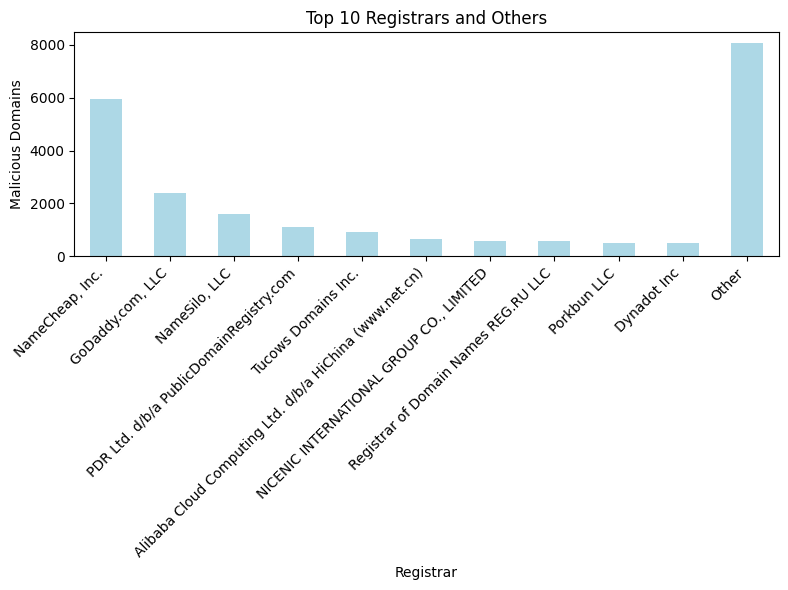

In [30]:
#
# Which registars had the most complaints?
#

import matplotlib.pyplot as plt

# Count the occurrence of each registrar and get top 10
registrar_counts = bad_domains['registrar'].value_counts()
top_10 = registrar_counts.head(10)

# Sum the rest and label as 'Other'
other_count = registrar_counts.iloc[10:].sum()
other_series = pd.Series({'Other': other_count})
top_10 = pd.concat([top_10, other_series])

# Plot the results
plt.figure(figsize=(8, 6))
top_10.plot(kind='bar', color='lightblue')
plt.title('Top 10 Registrars and Others')
plt.xlabel('Registrar')
plt.ylabel('Malicious Domains')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
#
# Which registrars had the most malicious domains per total # of domains registered?
#

# Step 1: Count the number of malicious domains per registrar
# Group by registrar_id and count the domains, while preserving the registrar name
malicious_domain_count = bad_domains.groupby(['registrar_id', 'registrar'])['domain'].count().reset_index()
malicious_domain_count.rename(columns={'domain': 'malicious_domains'}, inplace=True)

# Step 2: Merge with the registrar domain count to get the total number of domains each registrar has
registrar_domain_count_copy = registrar_domain_count[['id', 'name', 'domains']].copy()
registrar_domain_count_copy.rename(columns={'id': 'registrar_id', 'domains': 'total_domains'}, inplace=True)
merged_data = pd.merge(malicious_domain_count, registrar_domain_count_copy, on='registrar_id', how='inner')

# Step 2.5: Apply a (arbitrary) threshold for a minimum number of domains tracked to a registrar
min_domains_threshold = 1000
merged_data = merged_data[merged_data['total_domains'] >= min_domains_threshold]

# Step 3: Calculate the ratio of malicious domains to total domains registered for each registrar
merged_data['malicious_ratio'] = merged_data['malicious_domains'] / merged_data['total_domains']

# Step 4: Sort by the malicious ratio in descending order to find the registrars with the highest ratio
sorted_data = merged_data.sort_values(by='malicious_ratio', ascending=False).reset_index()

# Display the top registrars with the highest ratio of malicious domains
sorted_data[['registrar_id', 'registrar', 'malicious_domains', 'total_domains', 'malicious_ratio']].to_csv(USER_DIR + 'most_malicious.csv', index=False)

In [ ]:
#
# Is there any correlation between price drops and malicious domain purchases?
#  - How we quality a price drop: Look back n days from the purchase date. If price went down more than 5%?, that counts as a price drop
#


In [ ]:
#
# Is accepting certain payment methods (like crypto) correlated with more malicious domains?
#  - Need to match tld list service data with registrar_id's
#


In [ ]:
#
# What free services are correlated to more malicious domains (if any)?
#
